<a href="https://colab.research.google.com/github/AlessiaLombarda/AMD_project/blob/main/AMD_Link_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Link Analysis on IMDb Dataset**

# Environnment setup

In [ ]:
import os
import time
from google.colab import files
import pandas as pd
from pandas.core.common import flatten
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import logging

Removing *.log* files from the previous session

In [ ]:
!rm *.log

In [ ]:
!pip install ipython-autotime

%load_ext autotime

time: 154 µs (started: 2021-07-28 08:06:47 +00:00)


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark

time: 28.7 s (started: 2021-07-28 08:06:47 +00:00)


In [ ]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

time: 1.54 ms (started: 2021-07-28 08:07:16 +00:00)


In [ ]:
import findspark
findspark.init("spark-2.4.8-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

sc = spark.sparkContext

time: 4.58 s (started: 2021-07-28 08:07:16 +00:00)


# Loading data

In [ ]:
files.upload()
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

Saving kaggle.json to kaggle.json
time: 34.1 s (started: 2021-07-28 08:07:20 +00:00)


In [ ]:
!kaggle datasets download -d ashirwadsangwan/imdb-dataset
!unzip ./imdb-dataset.zip && rm ./imdb-dataset.zip

 99% 1.43G/1.44G [00:16<00:00, 110MB/s] 
100% 1.44G/1.44G [00:16<00:00, 95.9MB/s]
Archive:  ./imdb-dataset.zip
  inflating: name.basics.tsv.gz      
  inflating: name.basics.tsv/name.basics.tsv  
  inflating: title.akas.tsv.gz       
  inflating: title.akas.tsv/title.akas.tsv  
  inflating: title.basics.tsv.gz     
  inflating: title.basics.tsv/title.basics.tsv  
  inflating: title.principals.tsv.gz  
  inflating: title.principals.tsv/title.principals.tsv  
  inflating: title.ratings.tsv.gz    
  inflating: title.ratings.tsv/title.ratings.tsv  
time: 2min 2s (started: 2021-07-28 08:07:54 +00:00)


In [ ]:
df_principals = pd.read_csv('./title.principals.tsv/title.principals.tsv',  
                        usecols= ['tconst','nconst','category'], 
                        sep='\t',
                        na_values = ['\\N']).sort_values(by=['tconst'])
df_principals.head()

,tconst,nconst,category
0,tt0000001,nm1588970,self
1,tt0000001,nm0005690,director
2,tt0000001,nm0374658,cinematographer
3,tt0000002,nm0721526,director
4,tt0000002,nm1335271,composer


time: 1min 5s (started: 2021-07-28 08:09:57 +00:00)


In [ ]:
df_title_basics = pd.read_csv('./title.basics.tsv/title.basics.tsv',  
                        usecols= ['tconst', 'genres'], 
                        sep='\t',
                        na_values = ['\\N']).sort_values(by=['tconst'])

df_title_basics.head()                 

,tconst,genres
0,tt0000001,"Documentary,Short"
1,tt0000002,"Animation,Short"
2,tt0000003,"Animation,Comedy,Romance"
3,tt0000004,"Animation,Short"
4,tt0000005,"Comedy,Short"


time: 20.1 s (started: 2021-07-28 08:11:03 +00:00)


In [ ]:
df_name_basics= pd.read_csv('./name.basics.tsv/name.basics.tsv',  
                        usecols= ['nconst','primaryName'],
                        sep='\t',
                        na_values = ['\\N']).sort_values(by=['nconst'])
df_name_basics.head()

,nconst,primaryName
0,nm0000001,Fred Astaire
1,nm0000002,Lauren Bacall
2,nm0000003,Brigitte Bardot
3,nm0000004,John Belushi
4,nm0000005,Ingmar Bergman


time: 28.7 s (started: 2021-07-28 08:11:23 +00:00)


In [ ]:
df_ratings = pd.read_csv('./title.ratings.tsv/title.ratings.tsv',
                        sep='\t',
                        usecols = ['tconst', 'averageRating'],
                        na_values = ['\\N']).sort_values(by=['tconst'])
df_ratings.head()

,tconst,averageRating
0,tt0000001,5.6
1,tt0000002,6.1
2,tt0000003,6.5
3,tt0000004,6.2
4,tt0000005,6.1


time: 1.3 s (started: 2021-07-28 08:11:51 +00:00)


In [ ]:
print(f'Rows in df_principals: {len(df_principals)} \n\
Rows in df_title_basics: {len(df_title_basics)} \n\
Rows in df_name_basics: {len(df_name_basics)} \n\
Rows in df_ratings: {len(df_ratings)}')

Rows in df_principals: 36468817 
Rows in df_title_basics: 6321302 
Rows in df_name_basics: 9706922 
Rows in df_ratings: 993153
time: 2.63 ms (started: 2021-07-28 08:11:53 +00:00)


We now copy the variables in which the dataset is stored. In the first part of the notebook we will show how the dataset is preprocessed. Later, this process is then automated. The copies allow us to avoid to download again the dataset.

In [ ]:
df_principals_copy = df_principals
df_title_basics_copy = df_title_basics
df_name_basics_copy = df_name_basics
df_ratings_copy = df_ratings

time: 2.45 ms (started: 2021-07-28 08:11:53 +00:00)


# Data preprocessing

List of possible roles of people in the dataset

In [ ]:
print(f'Possible roles: \n{df_principals["category"].unique()}')

Possible roles: 
['self' 'director' 'cinematographer' 'composer' 'editor' 'producer'
 'actor' 'actress' 'writer' 'production_designer' 'archive_footage'
 'archive_sound']
time: 2.08 s (started: 2021-07-28 08:11:53 +00:00)


Elimination of NaN values (NaN in IMDb are intended as "\N")

In [ ]:
print(f'Length of df_title_basics before dropna: {len(df_title_basics)}')
df_title_basics.dropna(subset=["genres"], inplace=True)
print(f'Length of df_title_basics after dropna: {len(df_title_basics)}')

Length of df_title_basics before dropna: 6321302
Length of df_title_basics after dropna: 5819979
time: 591 ms (started: 2021-07-28 08:11:55 +00:00)


List of all possible genres in the dataset. 


In [ ]:
genres = []
for el in df_title_basics["genres"]:
  genres.append(el.split(","))

genres = list(set(flatten(genres))) #we flatten and then convert it to set to avoid duplicates
print(f'Possible genres: \n{genres}')


Possible genres: 
['Sport', 'Game-Show', 'Family', 'Sci-Fi', 'Reality-TV', 'Crime', 'Comedy', 'Adult', 'Western', 'Horror', 'Biography', 'Mystery', 'Romance', 'Drama', 'Adventure', 'News', 'Musical', 'Documentary', 'Fantasy', 'Talk-Show', 'Thriller', 'Film-Noir', 'Animation', 'Short', 'Music', 'War', 'Action', 'History']
time: 22.6 s (started: 2021-07-28 08:11:56 +00:00)


We then apply a filter to maintain only actors/actresses. 

In [ ]:
df_principals = df_principals[df_principals["category"].isin(["actor", "actress"])]
df_principals = df_principals[["tconst", "nconst"]]
df_principals.head()

,tconst,nconst
11,tt0000005,nm0443482
12,tt0000005,nm0653042
17,tt0000007,nm0183947
16,tt0000007,nm0179163
21,tt0000008,nm0653028


time: 2.36 s (started: 2021-07-28 08:12:18 +00:00)


Inner join between the dataframes to obtain a compact dataset (we use the inner join to keep only tuples with common key values)

In [ ]:
df_join = df_principals.merge(df_name_basics, on="nconst")
df_join = df_join.merge(df_title_basics, on="tconst")
df_join = df_join.merge(df_ratings, on="tconst")
df_join.head()

,tconst,nconst,primaryName,genres,averageRating
0,tt0000005,nm0443482,Charles Kayser,"Comedy,Short",6.1
1,tt0000005,nm0653042,John Ott,"Comedy,Short",6.1
2,tt0000007,nm0183947,Peter Courtney,"Short,Sport",5.5
3,tt0000007,nm0179163,James J. Corbett,"Short,Sport",5.5
4,tt0011603,nm0179163,James J. Corbett,Drama,3.0


time: 53 s (started: 2021-07-28 08:12:20 +00:00)


Dataset uniform sampling: the default value for the sampling rate is 0.1

In [ ]:
sampling_rate = 0.1
df_sample = df_join.sample(frac = sampling_rate).reset_index(drop=True)
df_sample.head()

,tconst,nconst,primaryName,genres,averageRating
0,tt0698287,nm0799736,Dick Simmons,"Action,Western",7.0
1,tt0393050,nm0137770,Luciano B. Carlos,Drama,6.1
2,tt0074190,nm0786891,Delphine Seyrig,"Drama,Music,Mystery",6.6
3,tt1411937,nm1262844,Jennifer Love,Adult,7.5
4,tt1430096,nm2151543,Kamalinee Mukherjee,Drama,7.0


time: 1.19 s (started: 2021-07-28 08:13:13 +00:00)


In [ ]:
print(f'Length of the original dataset: {len(df_join)} \n\
Length of the sampled dataset: {len(df_sample)}')

Length of the original dataset: 3404433 
Length of the sampling dataset: 340443
time: 3.25 ms (started: 2021-07-28 08:13:15 +00:00)


We group all the operations done before in a function, *preprocess_dataset*

In [ ]:
def preprocess_dataset(df_title_basics, df_principals, df_name_basics, df_ratings, sampling_rate = 0.1):
  """
  This function preprocess the dataset dropping NaN values, merging the different dataframes and sampling it
  
  Args:
    df_title_basics : the dataset containing movies/Tv series/...
    df_principals : the dataset containing the association between actors and movies
    df_name_basics: the dataset containing the association between actors id and names 
    df_ratings: the dataset containing the ratings
    sampling_rate : the sampling rate, default = 0.1

  Returns:
    The preprocessed and sampled version of the dataset

  """
  
  df_title_basics.dropna(subset=["genres"], inplace=True)

  #select actors only
  df_principals = df_principals[df_principals["category"].isin(["actor", "actress"])]
  df_principals = df_principals[["tconst", "nconst"]]
  
  #join
  df_join = df_principals.merge(df_name_basics, on="nconst")
  df_join = df_join.merge(df_title_basics, on="tconst")
  df_join = df_join.merge(df_ratings, on="tconst")
  
  #sampling
  df_sample = df_join.sample(frac = sampling_rate).reset_index(drop=True)
  print(f'Sample size: {len(df_sample)}')
  
  return df_sample

time: 14.5 ms (started: 2021-07-28 08:13:15 +00:00)


Creation of dictionaries to keep track of actors acting in a given movie and movies in which an actor has performed.
All these operations are then synthetized in functions, to easily run the algorithms

In [ ]:
 actors_enum = df_sample["nconst"].unique()
 movies_dict = {movie : [] for movie in df_sample["tconst"].unique()}
 actors_dict = {actor : [[], i] for actor, i in zip(actors_enum, range(len(actors_enum)))} #the value is composed by the list of movies and the id of the actor

for i in range(len(df_sample["tconst"])) :
   movies_dict[df_sample["tconst"][i]].append(df_sample["nconst"][i])
   actors_dict[df_sample["nconst"][i]][0].append(df_sample["tconst"][i])

time: 10.5 s (started: 2021-07-28 08:13:15 +00:00)


In [ ]:
print(f'Example from movies_dict: {next(iter(movies_dict.values()))}')

Example from movies_dict: ['nm0799736']
time: 2.28 ms (started: 2021-07-28 08:13:25 +00:00)


In [ ]:
print(f'Example from actors_dict: {next(iter(actors_dict.values()))}')

Example from actors_dict: [['tt0698287', 'tt0698245', 'tt0852883', 'tt0698270', 'tt0698264', 'tt0698259', 'tt0852885'], 0]
time: 2.22 ms (started: 2021-07-28 08:13:25 +00:00)


Creation of a dictionary to keep track of the correspondance between genres and actors

In [ ]:
genres_dict = {genre : [] for genre in genres}

for _, row in df_sample.iterrows():
  for el in row["genres"].split(","): 
    genres_dict [el].append(row["nconst"])

for el in genres_dict: 
  genres_dict [el] = list(set(genres_dict [el]))

time: 32.1 s (started: 2021-07-28 08:13:25 +00:00)


In [ ]:
print(f'Example from genres_dict: {next(iter(genres_dict.values()))[:10]}')

Example from genres_dict: ['nm0514517', 'nm2529463', 'nm5008318', 'nm8250743', 'nm1191244', 'nm0479471', 'nm9482126', 'nm4918405', 'nm7933891', 'nm0428838']
time: 2.18 ms (started: 2021-07-28 08:13:57 +00:00)


Creation of a dictionary that links actors that performed in the same project

In [ ]:
links = {actor : [] for actor in actors_enum}

for actor in actors_enum:
  for movie in actors_dict[actor][0] :
    links[actor].append(movies_dict[movie])
  links[actor] = list(set(flatten(links[actor]))) 

time: 2.05 s (started: 2021-07-28 08:13:57 +00:00)


In [ ]:
print(f'Example from links: {next(iter(links.values()))}')

Example from links: ['nm0799736', 'nm0376415', 'nm0211402']
time: 2.37 ms (started: 2021-07-28 08:13:59 +00:00)


In [ ]:
print(f'Total number of actors: {len(df_sample["nconst"].unique())}')

Total number of actors: 153337
time: 208 ms (started: 2021-07-28 08:13:59 +00:00)


Creation of a dictionary that associates to each actor the average rating obtained by the movies in which he performed

In [ ]:
avg_ratings = {actor : 0 for actor in actors_enum}

for i in range(len(df_sample)):
  avg_ratings[df_sample["nconst"][i]] += df_sample["averageRating"][i]

for el in avg_ratings:
  avg_ratings[el] /= 10 * len(actors_dict[el][0])


time: 5.43 s (started: 2021-07-28 08:14:00 +00:00)


In [ ]:
print(f'Example from avg_ratings: {next(iter(avg_ratings.values())):.2f}')

Example from avg_ratings: 0.73
time: 2.51 ms (started: 2021-07-28 08:14:05 +00:00)


The following is a toy example that show a subgraph obtained by the original dataset

In [ ]:
def get_subgraph(df_sample, links, out_degree):
  """
    This function create and visualize a subgraph extracted from the sampled version of the merged dataset
    
    Args:
      df_sample : the considered dataset
      links : the dictionary that keeps the correspondance between each actor and the actors he/she worked with
      out_degree : the minimum numer of outer links a node might have in order to be chosen 
      
    Returns:
      the visualization of the subgraph 
  """

  plt.rcParams["figure.figsize"] = (10,10)
  g = nx.DiGraph()

  for actor in links:
    if len(links[actor])>=out_degree:
      first_actor = actor

  for actor in links[first_actor]:
    g.add_node(actor)

  for actor in links[first_actor]:
    if (first_actor != actor) :
      g.add_edge(first_actor, actor)

  for actor in g.nodes:
    if(first_actor != actor):
      for actor2 in links[actor]:
        if actor2 in g.nodes:
          g.add_edge(actor, actor2)

  name_dict = {actor : "" for actor in g.nodes}
  for actor in name_dict:
    name_dict[actor] = df_sample[df_sample["nconst"] == actor]["primaryName"].unique()[0]

  opts = {'node_size': 1800, 
        'font_color': 'black',
        'font_size': 15,
        'font_weight': 'bold',
        'edge_color':'b',
        'arrowsize': 20}

  nx.draw(g, node_color='#AAAAEE', with_labels=True, labels=name_dict, **opts)
  
  plt.show()

time: 60.3 ms (started: 2021-07-28 08:14:05 +00:00)


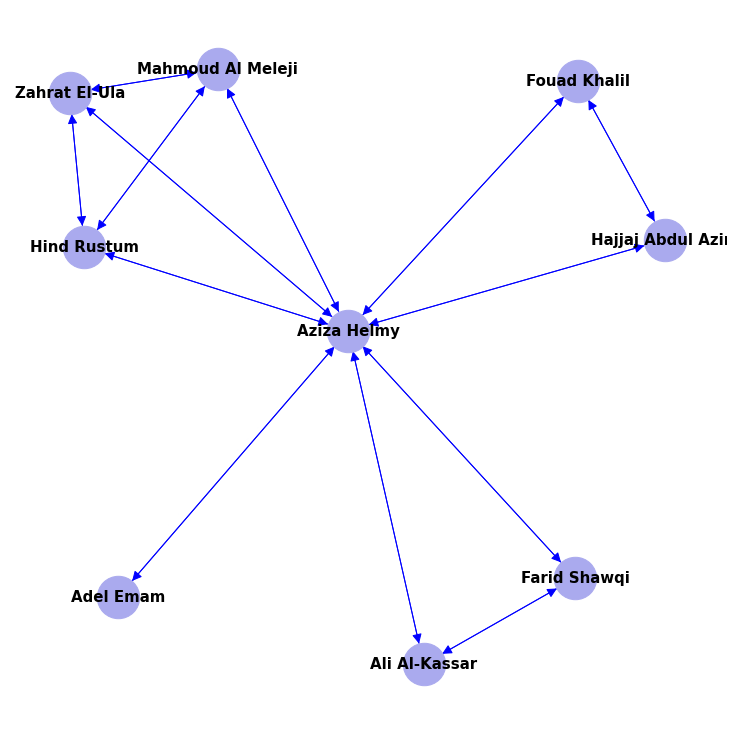

time: 1.73 s (started: 2021-07-28 08:14:05 +00:00)


In [ ]:
get_subgraph(df_sample, links, 9)

# PageRank

##Functions

In [ ]:
def get_genres(df_title_basics):
  """
    This function extracts all possible genres from the IMDb movies dataset

    Args:
      df_title_basics : the dataset from which we want to extract the genres
    
    Returns:
      the list of all possible genres of the products in the dataset
  """
  
  genres = []
  for el in df_title_basics["genres"]:
    genres.append(el.split(","))

  genres = list(set(flatten(genres)))
  return genres

def get_actors(df_sample):
  """
    This function extracts all possible actors from the IMDb movies dataset

    Args:
      df_sample : the dataset from which we want to extract the actors
    
    Returns:
      the list of all the actors in the dataset
  """

  return  df_sample["nconst"].unique()

time: 9.81 ms (started: 2021-07-28 08:14:07 +00:00)


In [ ]:
def create_dicts(df_sample, actors_enum):
  """
    This function creates two dictionaries that associate each actor to the movies he/she performed in and each product with the cast that worked in it

    Args:
      df_sample : the dataset we want to extract informations from
      actors_enum : the list of all considered actors

    Returns:
      a dictionary containing for each product the cast that performed in it, a dictionary containing for each actor the movies in which he/she performed and an ID to univoquely identify him/her
  """

  movies_dict = {movie : [] for movie in df_sample["tconst"].unique()}
  actors_dict = {actor : [[], i] for actor, i in zip(actors_enum, range(len(actors_enum)))}

  for i in range(len(df_sample["tconst"])) :
    movies_dict[df_sample["tconst"][i]].append(df_sample["nconst"][i])
    actors_dict[df_sample["nconst"][i]][0].append(df_sample["tconst"][i])

  return movies_dict, actors_dict

def create_genres_dict(df_sample, genres):
  """
    This function creates a dictionary that associate each genre to the actors related to it

    Args:
      df_sample : the dataset we want to extract informations from
      genres : the list of all possible genres in the dataset

    Returns:
      a dictionary containing for each genre the actors related to it
  """

  genres_dict = {genre : [] for genre in genres}

  for _, row in df_sample.iterrows():
    for el in row["genres"].split(","): 
      genres_dict [el].append(row["nconst"])

  for el in genres_dict: 
    genres_dict [el] = list(set(genres_dict[el]))

  return genres_dict

def create_ratings_dict(df_sample, actors_enum, actors_dict):
  """
    This function creates a dictionary that associate each actor to the average rating of the movies he/she performed in

    Args:
      df_sample : the dataset we want to extract informations from
      actors_enum : the list of all considered actors
      actors_dict : a dictionary containing for each actor the movies in which he/she performed and an ID to univocally identify him/her

    Returns:
      a dictionary containing for each actor the average rating of the movies he/she performed in
  """

  avg_ratings = {actor : 0 for actor in actors_enum}
  
  for i in range(len(df_sample)):
    avg_ratings[df_sample["nconst"][i]] += df_sample["averageRating"][i]

  for el in avg_ratings:
    avg_ratings[el] /= 10 * len(actors_dict[el][0])

  return avg_ratings  

def get_links(actors_enum, movies_dict, actors_dict):
  """
    This function creates a dictionary that associate each actor to the actors he/she performed with

    Args:
      df_sample : the dataset we want to extract informations from
      actors_enum : the list of all considered actors
      movies_dict : a dictionary containing for each product the cast that performed in it
      actors_dict : a dictionary containing for each actor the movies in which he/she performed and an ID to univoquely identify him/her

    Returns:
      a dictionary containing for each actor the actors he/she performed with
  """
  
  links = {actor : [] for actor in actors_enum}

  for actor in actors_enum:
    for movie in actors_dict[actor][0] :
      links[actor].append(movies_dict[movie])
    links[actor] = list(set(flatten(links[actor]))) 

  return links

time: 51.6 ms (started: 2021-07-28 08:14:07 +00:00)


In [ ]:
def create_connection_matrix(links):
    """
      This function creates the connection matrix

      Args:
        links : a dictionary containing for each actor the actors he/she performed with

      Returns:
        a connection matrix  whose entries are in the form (act2, act1, 1/num_outer_links_act1)
    """

    connection_matrix = []
    for a in links:
      for b in links[a]:
        connection_matrix.append((b, a, 1./len(links[a])))
    
    return connection_matrix

time: 5.31 ms (started: 2021-07-28 08:14:07 +00:00)


In [ ]:
def get_page_rank(actors_enum, links, actors_dict, logger, beta=0.8,
                  max_iterations=400, tolerance=1.e-5, verbose=False):
    """
      Page Rank algorithm
      
      Args:
        actors_enum : list of all possible actors
        links : the association between actors that worked in the same project
        actors_dict : the association between actors and projects in which they took part
        logger : the logger used to write to the correspondent log file
        beta : the parameter regulating teleporting, if equals 1 it leads to the basic version of pagerank without taxation (default = 0.8)
        max_iterations : the maximum number of iteration allowed (default = 400)
        tolerance : the minimum difference between actual and old page rank (default = 1.e-5)
        verbose : boolean, if True at each iteration print computed pagerank 

      Returns: 
        the computed page rank for each actor
    """

    connection_matrix = create_connection_matrix(links)
    rdd = sc.parallelize(connection_matrix).cache()

    n = len(actors_enum)
    page_rank = np.ones(n)/n
    old_page_rank = np.ones(n)
    
    iteration = 0
    while np.linalg.norm(old_page_rank - page_rank) >= tolerance and iteration < max_iterations:
        old_page_rank = page_rank
        page_rank_values = (rdd.map(lambda t: (actors_dict[t[0]][1], t[2]*page_rank[actors_dict[t[1]][1]]))
                            .reduceByKey(lambda a, b: a+b)
                            .sortByKey()
                            .collect()
                           )
        page_rank = np.array([beta*c + (1-beta)/n
                              for (i, c) in page_rank_values])
            
        if verbose:
            print(page_rank)

        iteration += 1
        
    print('{} iterations'.format(iteration))
    logger.info(f'Iterations: {iteration}')
    
    return page_rank

time: 26.6 ms (started: 2021-07-28 08:14:07 +00:00)


In [ ]:
def get_topic_page_rank(actors_enum, links, actors_dict, topics, genres_dict, logger, trustrank = False, beta=0.8,
                  max_iterations=400, tolerance=1.e-5, verbose=False):
  
    """
      Topic Sensitive Page Rank algorithm

      Args:
        actors_enum : list of all possible actors
        links : the association between actors that worked in the same project
        actors_dict : the association between actors and projects in which they took part
        topics : the list of preferred topics (or the trusted pages if trustrank = True)
        genres_dict : a dictionary containing for each genre the products related to it
        logger : the logger used to write to the correspondent log file
        trustrank : if True we're computing the Trustrank variant of the algorithm
        beta : the parameter regulating teleporting, if equals 1 it leads to the basic version of pagerank without taxation (default = 0.8)
        max_iterations : the maximum number of iteration allowed (default = 400)
        tolerance : the minimum difference between actual and old page rank (default = 1.e-5)
        verbose : boolean, if True at each iteration print computed pagerank 

      Returns: 
        the computed page rank for each actor
    """

    connection_matrix = create_connection_matrix(links)
    rdd = sc.parallelize(connection_matrix).cache()

    n = len(actors_enum)
    page_rank = np.ones(n)/n
    old_page_rank = np.ones(n)

    if (not trustrank):
      s = 0
      for el in topics: 
        s += len(genres_dict[el])
      if s == 0:  # There are not any movies about these topics in the sample
        logger.info('Number of movies about these topics in the sample = 0')    
        beta = 1    # Therefore, we are performing a Topic Sensitive PageRank without taxation (beta = 1)
        s = 1     # In order to avoid problems by dividing by zero
    else:
      s = np.sum(topics)

    iteration = 0
    while np.linalg.norm(old_page_rank - page_rank) >= tolerance and iteration < max_iterations:
        old_page_rank = page_rank
        page_rank_values = (rdd.map(lambda t: (actors_dict[t[0]][1], t[2]*page_rank[actors_dict[t[1]][1]]))
                            .reduceByKey(lambda a, b: a+b)
                            .sortByKey()
                            .collect()
                           )
        page_rank = np.array([beta*c + (1-beta)/s
                              for (i, c) in page_rank_values])
            
        if verbose:
            print(page_rank)

        iteration += 1
        
    print('{} iterations'.format(iteration))
    logger.info(f'Iterations: {iteration}')
    
    return page_rank

time: 39 ms (started: 2021-07-28 08:14:07 +00:00)


In [ ]:
def get_spam_mass(actors_enum, links, actors_dict, logger, beta=0.8,
                  max_iterations=400, tolerance=1.e-5, verbose=False):
  """
    Trust Rank algorithm
    The Trust Rank is obtained as the ratio between the number of projects in which the actor took part divided by the maximum number of projects in which an actor took part
    TrustRank is like Topic-sensitive PageRank, where the “topic” is a set of nodes believed to be trustworthy (not spam)
    
    Args:
      actors_enum: list of all possible actors
      links: the association between actors that worked in the same project
      actors_dict: the association between actors and projects in which they took part
      logger : the logger used to write to the correspondent log file
      beta: the parameter regulating teleporting, if equals 1 it leads to the basic version of pagerank without taxation (default = 0.8)
      max_iterations: the maximum number of iteration allowed (default = 400)
      tolerance: the minimum difference between actual and old page rank (default = 1.e-5)
      verbose: boolean, if True at each iteration print computed pagerank 
    
    Returns:
      the computed spam mass for each actor; the spam mass is obtained as the ratio between the difference of Page Rank and Trust Rank and the Trust Rank itself
  """
    
  page_rank = get_page_rank(actors_enum, links, actors_dict, logger, beta, max_iterations, tolerance, verbose)

  mean = np.mean(np.array([len(actors_dict[actor][0]) for actor in actors_enum]))

  trust_topics = np.array([1 if len(actors_dict[actor][0]) >= mean else 0 for actor in actors_enum])
  trust_rank = get_topic_page_rank(actors_enum, links, actors_dict, trust_topics, _, logger, trustrank=True, max_iterations=max_iterations) 

  spam_mass = (page_rank - trust_rank)/trust_rank

  return spam_mass

time: 14.8 ms (started: 2021-07-28 08:14:07 +00:00)


In [ ]:
def get_spam_mass_ratings(actors_enum, links, actors_dict, avg_ratings, logger, beta=0.8,
                  max_iterations=400, tolerance=1.e-5, verbose=False):
  """
    Trust Rank algorithm
    The Trust Rank is obtained as the the average rating given to the products in which an actor took part
    
    Args:
      actors_enum : list of all possible actors
      links : the association between actors that worked in the same project
      actors_dict : the association between actors and projects in which they took part
      avg_ratings : the association between actors and their average rating on projects in which they have taken part
      logger : the logger used to write to the correspondent log file
      beta : the parameter regulating teleporting, if equals 1 it leads to the basic version of pagerank without taxation (default = 0.8)
      max_iterations : the maximum number of iteration allowed (default = 400)
      tolerance : the minimum difference between actual and old page rank (default = 1.e-5)
      verbose : boolean, if True at each iteration print computed pagerank 
    
    Returns: 
      the computed spam mass for each actor; the spam mass is obtained as the ratio between the difference of Page Rank and Trust Rank and the Trust Rank itself
  """
    
  page_rank = get_page_rank(actors_enum, links, actors_dict, logger, beta, max_iterations, tolerance, verbose)

  mean = np.mean(np.array([avg_ratings[actor] for actor in avg_ratings]))
  trust_topics = np.array([1 if avg_ratings[actor] >= mean else 0 for actor in avg_ratings])

  trust_rank = get_topic_page_rank(actors_enum, links, actors_dict, trust_topics, _, logger, trustrank= True, max_iterations=max_iterations) 

  spam_mass = (page_rank - trust_rank)/trust_rank

  return spam_mass

time: 12.6 ms (started: 2021-07-28 08:14:07 +00:00)


In [ ]:
def setup_logger(name, log_file, level=logging.INFO):
    """
      To setup as many loggers as needed
      
      Args:
        name : name of the logger
        log_file : name of the correspondent log fileprint computed pagerank 
        level : level of the log (info, warning, ...)

      Returns: 
        the created logger
      """    

    formatter = logging.Formatter('%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
    handler = logging.FileHandler(log_file)        
    handler.setFormatter(formatter)

    logger = logging.getLogger(name)
    logger.setLevel(level)
    logger.addHandler(handler)

    return logger

time: 14.6 ms (started: 2021-07-28 08:14:07 +00:00)


## Basic implementation

*n* is the number of times you want to repeat the experiment

In [ ]:
n = 5

logger_pagerank = setup_logger('experiments_pagerank', 'experiments_pagerank.log')
for iter in range(n):
  logger_pagerank.info('This experiment implements PageRank')

  s_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
  time_basic = np.zeros(len(s_rates))

  for i in range(len(s_rates)):
    df_sample = preprocess_dataset(df_title_basics_copy, df_principals_copy, df_name_basics_copy, df_ratings_copy, sampling_rate = s_rates[i])
    actors_enum = get_actors(df_sample)
  
    movies_dict, actors_dict = create_dicts(df_sample, actors_enum)
    links = get_links(actors_enum, movies_dict, actors_dict)

    tic = time.time()
    get_page_rank(actors_enum, links, actors_dict, logger_pagerank, beta=1, max_iterations = 150)
    toc = time.time()
    time_basic[i] = toc-tic
    logger_pagerank.info(f'Sampling: {s_rates[i]}, Time: {time_basic[i]}')
    print(time_basic[i]) 

Sample size: 34
1 iterations
2.92781925201416
Sample size: 340
1 iterations
0.5964717864990234
Sample size: 3404
1 iterations
0.7191576957702637
Sample size: 34044
3 iterations
6.947958946228027
Sample size: 340443
9 iterations
93.59589648246765
time: 6min 35s (started: 2021-07-28 08:14:07 +00:00)


In [ ]:
files.download('experiments_pagerank.log')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 10 ms (started: 2021-07-28 08:20:43 +00:00)


## Pagerank with taxation

In [ ]:
n = 5

logger_taxation = setup_logger('experiments_taxation', 'experiments_taxation.log')
for iter in range(n):
  logger_taxation.info('This experiment implements PageRank with taxation')

  s_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
  time_taxation =  np.zeros(len(s_rates))

  for i in range(len(s_rates)):
    df_sample = preprocess_dataset(df_title_basics_copy, df_principals_copy, df_name_basics_copy, df_ratings_copy, sampling_rate = s_rates[i])
    actors_enum = get_actors(df_sample)
  
    movies_dict, actors_dict = create_dicts(df_sample, actors_enum)
    links = get_links(actors_enum, movies_dict, actors_dict)

    tic = time.time()
    get_page_rank(actors_enum, links, actors_dict, logger_taxation, max_iterations = 150)
    toc = time.time()
    time_taxation[i] = toc-tic
    logger_taxation.info(f'Sampling: {s_rates[i]}, Time: {time_taxation[i]}')
    print(time_taxation[i]) 

Sample size: 34
1 iterations
0.4020657539367676
Sample size: 340
1 iterations
0.4243457317352295
Sample size: 3404
1 iterations
0.5778684616088867
Sample size: 34044
2 iterations
3.560685873031616
Sample size: 340443
5 iterations
50.08156967163086
time: 6min (started: 2021-07-28 08:20:43 +00:00)


In [ ]:
files.download('experiments_taxation.log')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 10 ms (started: 2021-07-28 08:26:44 +00:00)


## Topic-sensitive pagerank

In [ ]:
n = 5

logger_topic_pagerank = setup_logger('experiments_topic_pagerank', 'experiments_topic_pagerank.log')

for iter in range(n):
  logger_topic_pagerank.info('This experiment implements Topic-Sensitive PageRank')

  s_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
  time_topic = np.zeros(len(s_rates))

  for i in range(len(s_rates)):
    df_sample = preprocess_dataset(df_title_basics_copy, df_principals_copy, df_name_basics_copy, df_ratings_copy, sampling_rate = s_rates[i])
    actors_enum = get_actors(df_sample)
    genres = get_genres(df_title_basics_copy)
  
    movies_dict, actors_dict = create_dicts(df_sample, actors_enum)
    genres_dict = create_genres_dict(df_sample, genres)
    links = get_links(actors_enum, movies_dict, actors_dict)

    tic = time.time()
    get_topic_page_rank(actors_enum, links, actors_dict, ['Western', 'Fantasy', 'Horror'], genres_dict, logger_topic_pagerank, max_iterations = 150)
    toc = time.time()
    time_topic[i] = toc-tic
    logger_topic_pagerank.info(f'Sampling: {s_rates[i]}, Time: {time_topic[i]}')
    print(time_topic[i]) 

Sample size: 34
43 iterations
13.903594732284546
Sample size: 340
41 iterations
11.300460577011108
Sample size: 3404
37 iterations
15.99254059791565
Sample size: 34044
32 iterations
48.879093647003174
Sample size: 340443
26 iterations
244.44883942604065
time: 12min 59s (started: 2021-07-28 08:26:44 +00:00)


In [ ]:
files.download('experiments_topic_pagerank.log')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 7.68 ms (started: 2021-07-28 08:39:43 +00:00)


##Trust-rank variants


In [ ]:
n = 5

logger_trust_rank = setup_logger('experiments_trust_rank', 'experiments_trust_rank.log')

for iter in range(n):
  logger_trust_rank.info('This experiment implements TrustRank variant with numbers of movies')

  s_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
  time_trust =  np.zeros(len(s_rates))

  for i in range(len(s_rates)):
    df_sample = preprocess_dataset(df_title_basics_copy, df_principals_copy, df_name_basics_copy, df_ratings_copy, sampling_rate = s_rates[i])
    actors_enum = get_actors(df_sample)
  
    movies_dict, actors_dict = create_dicts(df_sample, actors_enum)
    links = get_links(actors_enum, movies_dict, actors_dict)

    tic = time.time()
    get_spam_mass(actors_enum, links, actors_dict, logger_trust_rank, max_iterations = 150)
    toc = time.time()
    time_trust[i] = toc-tic
    logger_trust_rank.info(f'Sampling: {s_rates[i]}, Time: {time_trust[i]}')
    print(time_trust[i])

Sample size: 34
1 iterations
1 iterations
0.457714319229126
Sample size: 340
1 iterations
56 iterations
13.972788572311401
Sample size: 3404
1 iterations
43 iterations
18.113204956054688
Sample size: 34044
2 iterations
30 iterations
53.10697650909424
Sample size: 340443
5 iterations
26 iterations
311.6343643665314
time: 11min 13s (started: 2021-07-28 08:39:43 +00:00)


In [ ]:
files.download('experiments_trust_rank.log')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 11.2 ms (started: 2021-07-28 08:50:56 +00:00)


In [ ]:
n = 5

logger_trust_rank_2 = setup_logger('experiments_trust_rank_2', 'experiments_trust_rank_2.log')

for iter in range(n):
  logger_trust_rank_2.info('This experiment implements TrustRank variant with ratings')

  s_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
  time_trust =  np.zeros(len(s_rates))

  for i in range(len(s_rates)):
    df_sample = preprocess_dataset(df_title_basics_copy, df_principals_copy, df_name_basics_copy, df_ratings_copy, sampling_rate = s_rates[i])
    actors_enum = get_actors(df_sample)
  
    movies_dict, actors_dict = create_dicts(df_sample, actors_enum)
    avg_ratings = create_ratings_dict(df_sample, actors_enum, actors_dict)
    links = get_links(actors_enum, movies_dict, actors_dict)

    tic = time.time()
    get_spam_mass_ratings(actors_enum, links, actors_dict, avg_ratings, logger_trust_rank_2, max_iterations = 150)
    toc = time.time()
    time_trust[i] = toc-tic
    logger_trust_rank_2.info(f'Sampling: {s_rates[i]}, Time: {time_trust[i]}')
    print(time_trust[i])

Sample size: 34
1 iterations
36 iterations
10.75549030303955
Sample size: 340
1 iterations
32 iterations
8.028670072555542
Sample size: 3404
1 iterations
27 iterations
11.452237129211426
Sample size: 34044
3 iterations
22 iterations
41.136189460754395
Sample size: 340443
5 iterations
18 iterations
234.96531558036804
time: 10min 11s (started: 2021-07-28 09:06:28 +00:00)


In [ ]:
files.download('experiments_trust_rank_2.log')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 12 ms (started: 2021-07-28 09:16:40 +00:00)


# Results 

In [ ]:
files = ['experiments_pagerank.log', 'experiments_taxation.log', 'experiments_topic_pagerank.log',
         'experiments_trust_rank.log', 'experiments_trust_rank_2.log']
M = []

for f in files: 
  file = open(f, 'r')
  lines = file.read().splitlines()
  file.close()
  
  x = []

  for i in lines: 
    pos = i.find("Time: ")
    if pos != -1: 
      x.append(float(i[pos + len("Time: "):]))
  M.append(x)

mean = [[0 for x in range(n)] for y in range(len(files))] 

for i in range(len(files)):
  for j in range(len(M[i])):  
    mean[i][j%n] += M[i][j]

mean = np.array(mean)
print(mean)
for i in range(len(files)): 
  mean[i] = mean [i] / n 

print(f'Time mean: \n {mean}')  

[[   5.63526082    2.03787136    4.31851244   21.55176067  441.57020879]
 [   2.37413907    2.09371567    2.58505917   16.62187123  248.39453101]
 [  68.6030817    56.9819026    74.00988674  245.68523312 1253.66059279]
 [   4.13595462   72.79008508   89.82586932  264.59408641 1548.9165976 ]
 [  44.19122648   40.21201086   55.07872534  196.08585811 1135.9462769 ]]
Time mean: 
 [[  1.12705216   0.40757427   0.86370249   4.31035213  88.31404176]
 [  0.47482781   0.41874313   0.51701183   3.32437425  49.6789062 ]
 [ 13.72061634  11.39638052  14.80197735  49.13704662 250.73211856]
 [  0.82719092  14.55801702  17.96517386  52.91881728 309.78331952]
 [  8.8382453    8.04240217  11.01574507  39.21717162 227.18925538]]


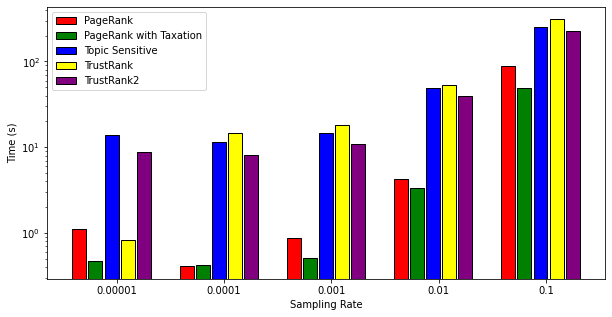

In [ ]:
plt.figure(figsize=[10, 5])
s_rate = ['0.00001', '0.0001', '0.001', '0.01', '0.1']

X = np.arange(len(s_rate))
plt.bar(X, mean[0], color = 'r', edgecolor = 'black', width = 0.13)
plt.bar(X + 0.15, mean[1], color = 'g', edgecolor = 'black', width = 0.13)
plt.bar(X + 2 * 0.15, mean[2], color = 'b', edgecolor = 'black', width = 0.13)
plt.bar(X + 3 * 0.15, mean[3], color = 'yellow',edgecolor = 'black', width = 0.13)
plt.bar(X + 4 * 0.15, mean[4], color = 'purple', edgecolor = 'black', width = 0.13)

plt.xticks([i + 0.35 for i in range(n)], s_rate)
plt.yscale('log')

plt.ylabel('Time (s)')
plt.xlabel('Sampling Rate')

plt.legend(['PageRank', 'PageRank with Taxation','Topic Sensitive', 'TrustRank1', 'TrustRank2'])
plt.savefig('time_algorithms.png')
plt.show()

In [ ]:
files = ['experiments_pagerank.log', 'experiments_taxation.log', 'experiments_topic_pagerank.log']
M = []

for f in files: 
  file = open(f, 'r')
  lines = file.read().splitlines()
  file.close()
  
  x = []

  for i in lines: 
    pos = i.find("Iterations: ")
    if pos != -1: 
      x.append(float(i[pos + len("Iterations: "):]))
  M.append(x)

mean = [[0 for x in range(n)] for y in range(len(files))] 

for i in range(len(files)):
  for j in range(len(M[i])):  
    mean[i][j%n] += M[i][j]
    

mean = np.array(mean)

for i in range(len(files)):
  mean[i] = mean [i] / n 

print(f'Mean iterations: \n {mean}')


Mean iterations: 
 [[ 1.   1.   1.4  2.4  9. ]
 [ 1.   1.   1.   2.   5. ]
 [48.2 41.4 36.8 31.6 26. ]]


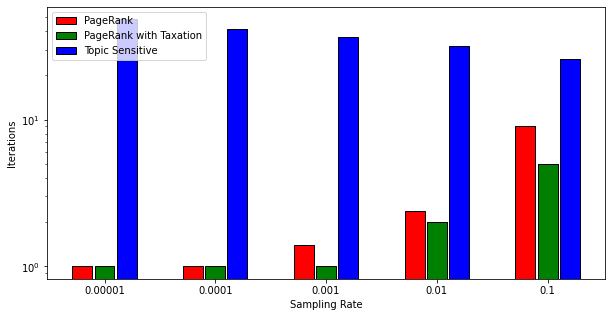

In [ ]:
plt.figure(figsize=[10, 5])
s_rate = ['0.00001', '0.0001', '0.001', '0.01', '0.1']

X = np.arange(len(s_rate))
plt.bar(X, mean[0], color = 'r', edgecolor = 'black', width = 0.18)
plt.bar(X + 0.20, mean[1], color = 'g', edgecolor = 'black', width = 0.18)
plt.bar(X + 2 * 0.20, mean[2], color = 'b', edgecolor = 'black', width = 0.18)

plt.xticks([i + 0.20 for i in range(n)], s_rate)
plt.yscale('log')

plt.ylabel('Iterations')
plt.xlabel('Sampling Rate')

plt.legend(['PageRank', 'PageRank with Taxation','Topic Sensitive'])
plt.savefig('iter_algorithms3.png')
plt.show()

In [ ]:
file = open('experiments_trust_rank.log', 'r')
lines = file.read().splitlines()
file.close()
  
x = []
for i in lines: 
  pos = i.find("Iterations: ")
  if pos != -1: 
    x.append(float(i[pos + len("Iterations: "):]))

mean_pr = np.zeros(n)
mean_topic = np.zeros(n)

j = 0
k = 0

for i in range(len(x)):
  if i%2 == 0:   
    mean_pr[j%n] += x[i]
    j+=1
    
  else: 
    mean_topic[k%n] += x[i] 
    k +=1

mean_pr /= n
mean_topic /= n
print(f'Mean iterations 1st-TrustRank using PageRank: {mean_pr}')
print(f'Mean iterations 1st-TrustRank using Topic Sensitive: {mean_topic}')


Mean iterations 1st-TrustRank using PageRank: [1. 1. 1. 2. 5.]
Mean iterations 1st-TrustRank using Topic Sensitive: [ 1.  57.  42.8 30.2 26. ]


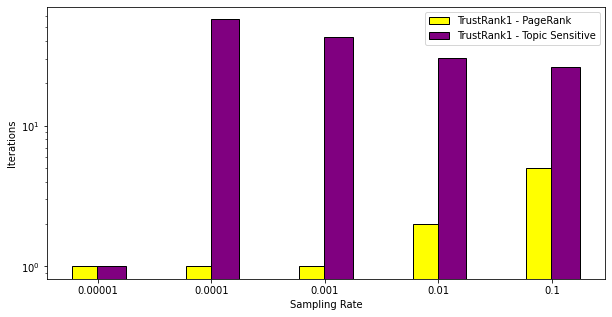

In [ ]:
plt.figure(figsize=[10, 5])
s_rate = ['0.00001', '0.0001', '0.001', '0.01', '0.1']

X = np.arange(len(s_rate))
plt.bar(X, mean_pr, color = 'yellow', edgecolor = 'black', width = 0.25)
plt.bar(X + 0.22, mean_topic, color = 'purple', edgecolor = 'black', width = 0.25)

plt.xticks([i + 0.10 for i in range(n)], s_rate)
plt.yscale('log')

plt.ylabel('Iterations')
plt.xlabel('Sampling Rate')

plt.legend(['TrustRank1 - PageRank', 'TrustRank1 - Topic Sensitive'])
plt.savefig('iter_algorithms_tr1.png')
plt.show()

In [ ]:
file = open('experiments_trust_rank_2.log', 'r')
lines = file.read().splitlines()
file.close()
  
x = []

for i in lines: 
  pos = i.find("Iterations: ")
  if pos != -1: 
    x.append(float(i[pos + len("Iterations: "):]))

mean_pr = np.zeros(n)
mean_topic = np.zeros(n)

j = 0
k = 0

for i in range(len(x)):
  if i%2 == 0:   
    mean_pr[j%n] += x[i]
    j+=1
    
  else: 
    mean_topic[k%n] += x[i] 
    k +=1

mean_pr /= n
mean_topic /= n
print(f'Mean iterations 2nd-TrustRank using PageRank: {mean_pr}')
print(f'Mean iterations 2dn-TrustRank using Topic Sensitive: {mean_topic}')

Mean iterations 2nd-TrustRank using PageRank: [1.  1.  1.  2.2 5. ]
Mean iterations 2dn-TrustRank using Topic Sensitive: [37.2 31.8 26.8 22.  18. ]


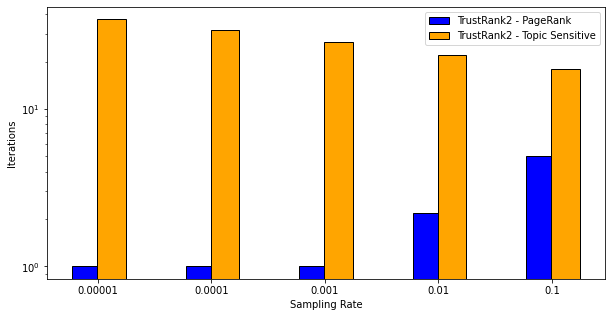

In [ ]:
plt.figure(figsize=[10, 5])
s_rate = ['0.00001', '0.0001', '0.001', '0.01', '0.1']

X = np.arange(len(s_rate))
plt.bar(X, mean_pr, color = 'b', edgecolor = 'black', width = 0.25)
plt.bar(X + 0.22, mean_topic, color = 'orange', edgecolor = 'black', width = 0.25)

plt.xticks([i + 0.10 for i in range(n)], s_rate)
plt.yscale('log')

plt.ylabel('Iterations')
plt.xlabel('Sampling Rate')

plt.legend(['TrustRank2 - PageRank', 'TrustRank2 - Topic Sensitive'])
plt.savefig('iter_algorithms_tr2.png')
plt.show()